In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lmfit
import math
#import seaborn as sns
#import astropy.stats as aps
#import statsmodels.api as sm
#from sklearn import linear_model


Lendo os Dados e plotando:

Text(0,0.5,'$\\Delta$ m(t)')

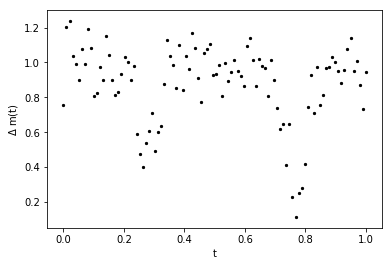

In [2]:
df = pd.read_csv('dataset_1.0.csv',skiprows=0)

plt.scatter(df.time,df.signal,s=5,color='black')

plt.xlabel('t')
plt.ylabel('$\Delta$ m(t)')

Vou plotar uma curva pra esses dados, das binárias eclipsantes, pra isso usarei a equação abaixo:

$\Delta$m(t) = $1 - A * exp(-(t-t_{1})^{2}/\zeta _{1}^{2}) - B*exp(-(t-t_{2})^{2}/\zeta _{2}^{2})$

Repare que o fluxo está normalizado, assim o eixo y representa apenas a variação em magnitudes em relação ao valor médio.

Assim tenho os parâmetros: A, B, t1, t2, z1 e z2, meu objetivo é utilizar ajuste por máxima verossimilhança para ver o best-fit para estes parâmetros. 

Para rodar, devo dar também um chute inicial (considerando a interpretação de cada variável, que está no relatório), tanto dos parâmetros do modelo como da função de verossimilhança: <br>
A=0.5 <br>
B=0.7 <br>
t1=0.3 <br>
t2=0.75 <br>
z1=0.05 <br>
z2=0.05 <br>
f=0.5 <br>


In [3]:
np.log(0.5)

-0.6931471805599453

In [4]:
A_true=0.5
B_true=0.7
t1_true=0.3 
t2_true=0.75 
z1_true=0.05 
z2_true=0.05 
f_true=0.5
x=df.time.values
y=df.signal.values
yerr=df.signal_err.values


def lnlike(theta,x,y,yerr):
    A,B,t1,t2,z1,z2, lnf = theta
    model = 1 - A*np.exp(-(x-t1)**2/z1**2) - B*np.exp(-(x-t2)**2/z2**2) 
    inv_sigma2=1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

import scipy.optimize as op

nll= lambda *args: -lnlike(*args)
result=op.minimize(nll, [A_true, B_true, t1_true, t2_true, z1_true, z2_true, np.log(f_true)], args=(x,y,yerr))
A_ml, B_ml, t1_ml, t2_ml, z1_ml, z2_ml, lnf_ml = result["x"]
result["x"]

array([ 0.50222417,  0.7821911 ,  0.27835047,  0.76806   ,  0.04913086,
        0.04950036, -2.70516755])

Agora vou plotar o modelo com os parâmetros obtidos pelo best-fit com aos dados fornecidos.

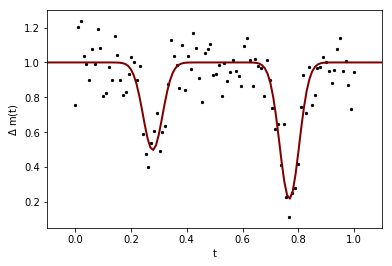

In [5]:
# Vendo o ajuste

plt.scatter(df.time,df.signal,s=5,color='black')

plt.xlabel('t')
plt.ylabel('$\Delta$ m(t)')

x=np.arange(-0.1,1.1,0.01)

plt.plot(x,1 - A_ml*np.exp(-(x-t1_ml)**2/z1_ml**2) - B_ml*np.exp(-(x-t2_ml)**2/z2_ml**2),color='maroon',linewidth=2)

plt.xlim(-0.1,1.1)

plt.savefig('ajustemle.pdf', format='pdf')

## MCMC

Aqui começo o método de MCMC, primeiro vou definir a função prior, vou usar o critério de 50% pra cima e pra baixo pra cada parâmetro, assim valores abaixo de 0,5 vezes o parâmetro ou acima de 1,5 vezes o parâmetro terão probabilidade nula na prior. Importante destacar que aqui eu calculo o valor logarítmico da prior. 


In [6]:
def lnprior(theta):
    A, B, t1, t2, z1, z2, lnf = theta
    if 0.5*A_ml < A < 1.5*A_ml and 0.5*B_ml < B < 1.5*B_ml and 0.5*t1_ml < t1 < 1.5*t1_ml and 0.5*t2_ml < t2 < 1.5*t2_ml and 0.5*z1_ml < z1 < 1.5*z1_ml and 0.5*z2_ml < z2 < 1.5*z2_ml and 0.5*lnf_ml < lnf < 1.5*lnf_ml:
        return 0.0
    return -np.inf

Agora faço a função de verossimilhança, que junto com a prior será utilizada para o cálculo da função posterior, que será utilizada no processo decisório do estado vencedor em cada passo. Assim como a prior, aqui calculo a versão logarítmica da função de verossimilhança.

In [7]:
x=df.time.values
y=df.signal.values
yerr=df.signal_err.values

def lnprob(theta,x,y,yerr):
    lp=lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,x,y,yerr)

Vou criar agora as bolhas gaussianas, serão 1000 cadeias com 7 dimensões (6 parâmetros mais ln(f)). Assim eu parto dos parâmetros obtidos com a função de verossimilhança para criação das cadeias.

In [8]:
# Criando as bolhas de estado gaussianas, as cadeias de Markov, serão 7 dimensões (conta lnf)
# e 100 bolhas, ou seja 100 estados iniciais dos parâmetros que serão evoluídos.

ndim,nwalkers=7,1000
pos=[result["x"] +1*10**(-4)*np.random.randn(ndim) for i in range(nwalkers)]


Abaixo, podemos ver que as cadeias estão guardadas na variável "pos", são 1000 cadeias de 7 dimensões.

In [9]:
np.shape(pos)

(1000, 7)

Abaixo eu uso o pacote EMCEE, e com o logaritmo da prior e da função de verossimilhança, e as cadeias definidas, eu escolhi um total de 1000 passos para rodar o MCMC.

In [10]:
import emcee
sampler=emcee.EnsembleSampler(nwalkers,ndim, lnprob, args=(x,y,yerr))
sampler.run_mcmc(pos,1000)

/home/fabio/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/fabio/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ 0.50222926,  0.78210619,  0.27838582, ...,  0.04914712,
          0.04959651, -2.7051713 ],
        [ 0.50235955,  0.78213888,  0.27848111, ...,  0.04908903,
          0.04956541, -2.70521263],
        [ 0.50212343,  0.78234889,  0.27827216, ...,  0.04911784,
          0.04955153, -2.70514751],
        ...,
        [ 0.50222569,  0.78202006,  0.27825398, ...,  0.04917394,
          0.04952866, -2.70504934],
        [ 0.50224839,  0.78215462,  0.27827732, ...,  0.0491105 ,
          0.04919959, -2.70524672],
        [ 0.50223774,  0.7821705 ,  0.27830003, ...,  0.04899982,
          0.04950641, -2.70492612]]),
 array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
   

Agora irei jogar fora os 50 primeiros valores aceitos de cada cadeia, o objetivo disto é reduzir o bias associado dos valores iniciais. Abaixo mostro a quantidade de parâmetros aceitos finais.

In [11]:
samples=sampler.chain[:,50:,:].reshape((-1,ndim))

np.shape(samples)

(950000, 7)

Salvo os parâmetros aceitos em um PANDAS dataframe.

In [12]:
MCMC=pd.DataFrame({'A':samples[:,0],'B':samples[:,1],'t1':samples[:,2],'t2':samples[:,3],'z1':samples[:,4],'z2':samples[:,5],'lnf':samples[:,6]})

MCMC

,A,B,t1,t2,z1,z2,lnf
0,0.502229,0.782106,0.278386,0.768048,0.049147,0.049597,-2.705171
1,0.502229,0.782106,0.278386,0.768048,0.049147,0.049597,-2.705171
2,0.502229,0.782106,0.278386,0.768048,0.049147,0.049597,-2.705171
3,0.502229,0.782106,0.278386,0.768048,0.049147,0.049597,-2.705171
4,0.502229,0.782106,0.278386,0.768048,0.049147,0.049597,-2.705171
5,0.502229,0.782106,0.278386,0.768048,0.049147,0.049597,-2.705171
6,0.502229,0.782106,0.278386,0.768048,0.049147,0.049597,-2.705171
7,0.502229,0.782106,0.278386,0.768048,0.049147,0.049597,-2.705171
8,0.502229,0.782106,0.278386,0.768048,0.049147,0.049597,-2.705171
9,0.502229,0.782106,0.278386,0.768048,0.049147,0.049597,-2.705171


Por fim, uso o pacote corner que vai me dar os triângulos plot, que oferecem tanto o histograma de cada parâmetro individual, como a relação entre cada dupla de variáveis. Além disso, as retas apresentadas são os best-fit obtidos inicialmente com a função de verossimilhança. Temos também a mediana de cada histograma e seus respectivos intervalos interquartis (25% e 75%), que possibilitam fazer o intervalo de confiança para cada parâmetro. 

Quantiles:
[(0.25, 0.5021569104456521), (0.5, 0.502220015389738), (0.75, 0.50228886237833)]
Quantiles:
[(0.25, 0.7821200333441741), (0.5, 0.7821880887808712), (0.75, 0.7822558885691051)]
Quantiles:
[(0.25, 0.2782857324257893), (0.5, 0.2783472606927752), (0.75, 0.2784138487166481)]
Quantiles:
[(0.25, 0.7679940754572738), (0.5, 0.7680608594695735), (0.75, 0.7681239940774996)]
Quantiles:
[(0.25, 0.049058003729401986), (0.5, 0.049130064353264793), (0.75, 0.04920078858098478)]
Quantiles:
[(0.25, 0.04943067059411227), (0.5, 0.04949996762442495), (0.75, 0.04956380407983846)]
Quantiles:
[(0.25, -2.7052383619431115), (0.5, -2.705170503571148), (0.75, -2.7051025812901797)]


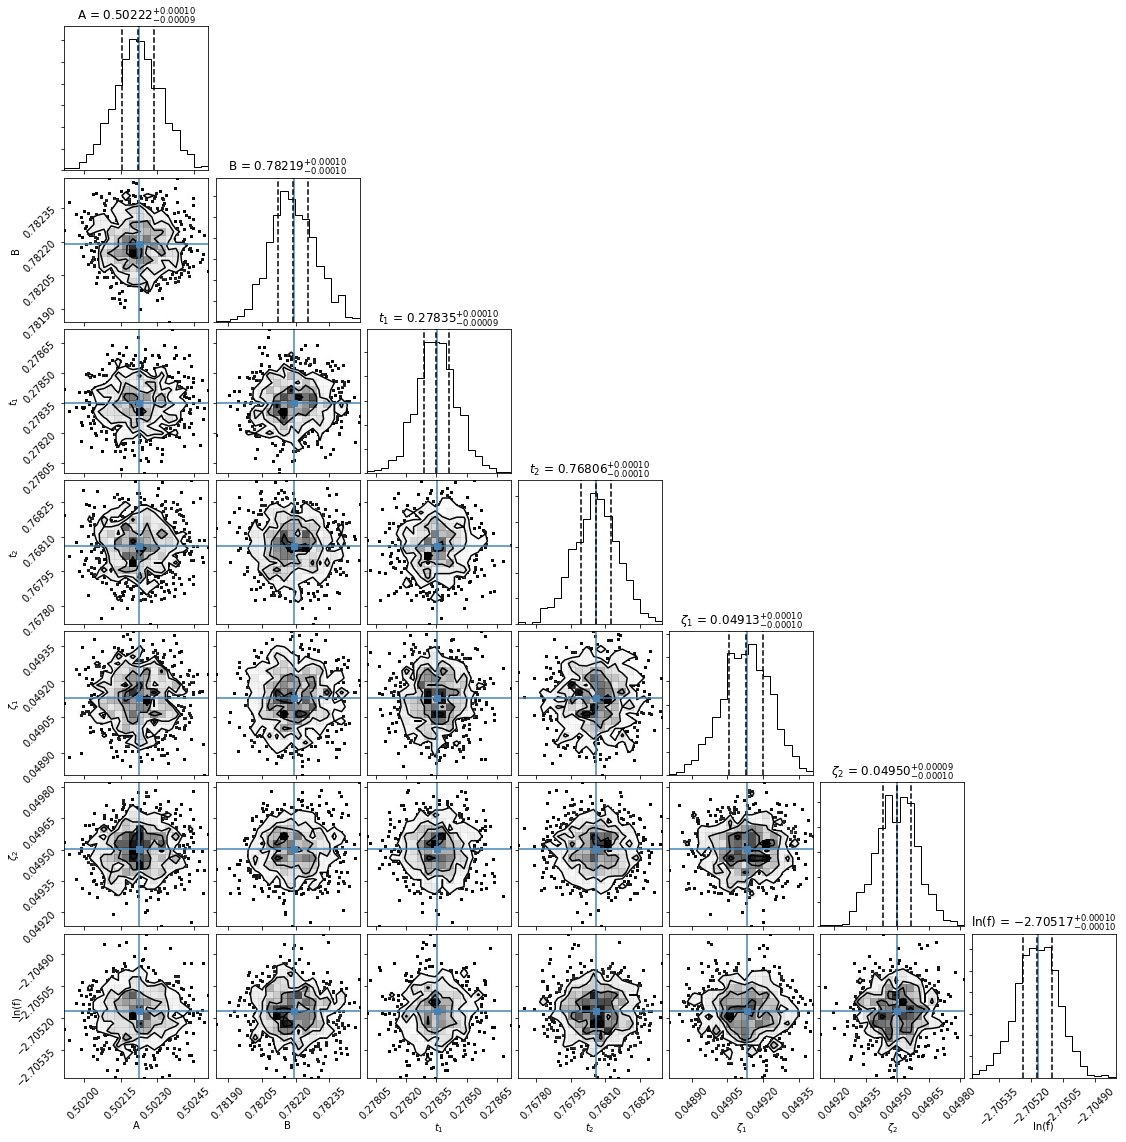

In [21]:
import corner

data = MCMC
figure = corner.corner(data, verbose=True, quantiles=[0.25,0.5,0.75], labels=["A", "B", "$t_{1}$", "$t_{2}$", "$\zeta_{1}$", "$\zeta_{2}$","ln(f)"], show_titles=True, title_fmt='.5f', title_kwargs={"fontsize": 12},figsize=2,truths=[A_ml,B_ml,t1_ml,t2_ml,z1_ml,z2_ml,lnf_ml])

plt.savefig('corner.pdf', format='pdf')

Abaixo calculo a diferença entre os best-fits dos parâmetros utilizando a função de verossimilhança e o resultado do MCMC, os resultados se mostram bastante coerentes, com os dados obtidos via MLE dentro das margens dos intervalos interquartis obtidos via MCMC.

In [17]:
A_delta=np.abs(MCMC.A.median()-A_ml)
B_delta=np.abs(MCMC.B.median()-B_ml)
t1_delta=np.abs(MCMC.t1.median()-t1_ml)
t2_delta=np.abs(MCMC.t2.median()-t2_ml)
z1_delta=np.abs(MCMC.z1.median()-z1_ml)
z2_delta=np.abs(MCMC.z2.median()-z2_ml)
lnf_delta=np.abs(MCMC.lnf.median()-lnf_ml)

print(A_delta)
print(B_delta)
print(t1_delta)
print(t2_delta)
print(z1_delta)
print(z2_delta)
print(lnf_delta)


4.1512211240712915e-06
3.007477113459167e-06
3.2125793578141604e-06
8.636696472441585e-07
7.924714619730877e-07
3.9711960748284314e-07
2.9558398515483475e-06
